In [562]:
import pandas as pd

# Load the dataset
file_path = 'students_data.csv'
students_df = pd.read_csv(file_path)

# Display the first few rows of the dataset
students_df.head()


,StudentID,Name,AcademicInterest,ExtracurricularActivities,Skills,Location,YearOfStudy,Major,GPA,Languages,ClubMemberships,ResearchInterests
0,1,Student 1,Psychology,Debate Club,Problem Solving,New York,Freshman,Psychology,3.27,"Chinese, Japanese, Spanish, German, French","Music Club, Art Club, Sports Team, Debate Club...",Biomedical Engineering
1,2,Student 2,Psychology,Debate Club,"Leadership, Problem Solving, Public Speaking, ...",Boston,Graduate,Physics,3.17,"French, English, Chinese, Spanish, Japanese","Art Club, Music Club, Sports Team, Coding Club",Urban Planning
2,3,Student 3,History,Volunteer Group,"Data Analysis, Leadership, Public Speaking, Ar...",Chicago,Junior,Biology,2.09,"Spanish, Japanese, German, French","Music Club, Art Club, Debate Club, Volunteer G...",Nanotechnology
3,4,Student 4,Computer Science,Volunteer Group,"Public Speaking, Data Analysis, Problem Solving",Chicago,Graduate,Biology,2.56,"Japanese, Chinese, Spanish, French","Sports Team, Volunteer Group",Space Exploration
4,5,Student 5,Computer Science,Sports Team,Data Analysis,Chicago,Graduate,Computer Science,2.01,English,"Sports Team, Volunteer Group, Music Club",Climate Change


In [563]:
def evaluate_recommender(recommendations, true_activities):
    # Convert the recommendations and true activities to sets
    recommended_set = set(recommendations['ExtracurricularActivities'])
    true_set = set(true_activities.split(', '))

    # Calculate precision, recall, and F1-score
    precision = len(recommended_set & true_set) / len(recommended_set)
    recall = len(recommended_set & true_set) / len(true_set)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f1


In [564]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_recommender(recommendations, true_activities):
    # Convert the recommendations and true activities to sets
    recommended_set = set(recommendations['ExtracurricularActivities'])
    true_set = set(true_activities.split(', '))

    # Create a union of all activities to use as labels
    all_activities = list(recommended_set.union(true_set))

    # Convert sets to binary format
    y_true = [1 if activity in true_set else 0 for activity in all_activities]
    y_pred = [1 if activity in recommended_set else 0 for activity in all_activities]

    # Calculate precision, recall, and F1-score using sklearn metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return precision, recall, f1


####ENHANCEMENT

####SECOND ENHANCEMENT

In [565]:
from sklearn.decomposition import PCA

# Combine features into a single string for each student with refined feature selection
students_df['combined_features'] = students_df['AcademicInterest'] + ' ' + \
                                   students_df['Skills'] + ' ' + \
                                   students_df['ResearchInterests'] + ' ' + \
                                   students_df['Languages'] + ' ' + \
                                   students_df['ClubMemberships']

# Initialize TF-IDF Vectorizer with additional parameters
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the combined features
tfidf_matrix = tfidf_vectorizer.fit_transform(students_df['combined_features'])

# Apply PCA for dimensionality reduction with adjusted components
pca = PCA(n_components=66)
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix.toarray())

# Calculate cosine similarity on reduced matrix
cosine_sim = cosine_similarity(tfidf_matrix_reduced, tfidf_matrix_reduced)

# Function to get recommendations with a similarity threshold
def get_recommendations(student_id, cosine_sim=cosine_sim, threshold=0.736):
    idx = students_df.index[students_df['StudentID'] == student_id].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = [score for score in sim_scores if score[1] > threshold]  # Apply similarity threshold
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10 similar students
    student_indices = [i[0] for i in sim_scores]
    return students_df.iloc[student_indices][['StudentID', 'Name', 'ExtracurricularActivities']]

# Example: Get recommendations for a student
recommendations_cos = get_recommendations(4)
recommendations_cos


,StudentID,Name,ExtracurricularActivities
151,152,Student 152,Coding Club
154,155,Student 155,Coding Club
537,538,Student 538,Volunteer Group


In [566]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Create a new dataframe with each student's ID and their activities
student_activities = students_df[['StudentID', 'ExtracurricularActivities']]

# Create the user-item interaction matrix
interaction_matrix = pd.get_dummies(student_activities.set_index('StudentID')['ExtracurricularActivities']).groupby(level=0).max()

# Apply SVD for matrix factorization with adjusted components
svd = TruncatedSVD(n_components=6)
interaction_matrix_reduced = svd.fit_transform(interaction_matrix)

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(interaction_matrix_reduced, interaction_matrix_reduced)

# Function to get collaborative filtering recommendations
def get_collab_recommendations(student_id, cosine_sim_matrix=cosine_sim_matrix):
    idx = interaction_matrix.index.get_loc(student_id)
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10 similar students
    student_indices = [interaction_matrix.index[i[0]] for i in sim_scores]
    return students_df[students_df['StudentID'].isin(student_indices)][['StudentID', 'Name', 'ExtracurricularActivities']]

# Example: Get collaborative filtering recommendations for a student
collab_recommendations_cos = get_collab_recommendations(4)
collab_recommendations_cos


,StudentID,Name,ExtracurricularActivities
3,4,Student 4,Volunteer Group
7,8,Student 8,Volunteer Group
17,18,Student 18,Volunteer Group
22,23,Student 23,Volunteer Group
27,28,Student 28,Volunteer Group
31,32,Student 32,Volunteer Group
33,34,Student 34,Volunteer Group
37,38,Student 38,Volunteer Group
43,44,Student 44,Volunteer Group
57,58,Student 58,Volunteer Group


###SECOND ENHANCEMENT WITH DIFFERENT SIMILARITIES

In [567]:
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine features into a single string for each student with refined feature selection
students_df['combined_features'] = students_df['AcademicInterest'] + ' ' + \
                                   students_df['Skills'] + ' ' + \
                                   students_df['ResearchInterests'] + ' ' + \
                                   students_df['Languages'] + ' ' + \
                                   students_df['ClubMemberships']

# Initialize TF-IDF Vectorizer with additional parameters
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the combined features
tfidf_matrix = tfidf_vectorizer.fit_transform(students_df['combined_features'])

# Apply PCA for dimensionality reduction with adjusted components
pca = PCA(n_components=66)
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix.toarray())

# Function to calculate Euclidean distance between rows of the matrix
def euclidean_distance_matrix(matrix):
    distances = np.zeros((matrix.shape[0], matrix.shape[0]))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[0]):
            if i != j:
                distances[i, j] = euclidean(matrix[i], matrix[j])
    return distances

# Calculate Euclidean distance on reduced matrix
euclidean_dist = euclidean_distance_matrix(tfidf_matrix_reduced)

# Function to get recommendations based on Euclidean distance
def get_recommendations(student_id, euclidean_dist=euclidean_dist, threshold=0.7):
    idx = students_df.index[students_df['StudentID'] == student_id].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = [score for score in sim_scores if score[1] > threshold]  # Apply similarity threshold
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10 similar students
    student_indices = [i[0] for i in sim_scores]
    return students_df.iloc[student_indices][['StudentID', 'Name', 'ExtracurricularActivities']]

# Example: Get recommendations for a student
recommendations_euc = get_recommendations(4)
recommendations_euc


,StudentID,Name,ExtracurricularActivities
151,152,Student 152,Coding Club
154,155,Student 155,Coding Club
537,538,Student 538,Volunteer Group
116,117,Student 117,Sports Team


In [568]:
from sklearn.decomposition import TruncatedSVD

# Create a new dataframe with each student's ID and their activities
student_activities = students_df[['StudentID', 'ExtracurricularActivities']]

# Create the user-item interaction matrix
interaction_matrix = pd.get_dummies(student_activities.set_index('StudentID')['ExtracurricularActivities']).groupby(level=0).max()

# Apply SVD for matrix factorization with adjusted components
svd = TruncatedSVD(n_components=6)
interaction_matrix_reduced = svd.fit_transform(interaction_matrix)

# Function to get collaborative filtering recommendations
def get_collab_recommendations(student_id, euclidean_dist=euclidean_dist, threshold=0.7):
    idx = interaction_matrix.index.get_loc(student_id)
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10 similar students
    student_indices = [interaction_matrix.index[i[0]] for i in sim_scores]
    return students_df[students_df['StudentID'].isin(student_indices)][['StudentID', 'Name', 'ExtracurricularActivities']]

# Example: Get collaborative filtering recommendations for a student
collab_recommendations_euc = get_collab_recommendations(4)
collab_recommendations_euc


,StudentID,Name,ExtracurricularActivities
3,4,Student 4,Volunteer Group
7,8,Student 8,Volunteer Group
17,18,Student 18,Volunteer Group
22,23,Student 23,Volunteer Group
27,28,Student 28,Volunteer Group
31,32,Student 32,Volunteer Group
33,34,Student 34,Volunteer Group
37,38,Student 38,Volunteer Group
43,44,Student 44,Volunteer Group
57,58,Student 58,Volunteer Group


In [569]:
# Evaluate the content-based recommender for a student
true_activities = students_df[students_df['StudentID'] == 4]['ExtracurricularActivities'].values[0]
content_precision_cos, content_recall_cos, content_f1_cos = evaluate_recommender(recommendations_cos, true_activities)
print("Content-Based Filtering - Precision: {}, Recall: {}, F1 Score: {}".format(content_precision_cos, content_recall_cos, content_f1_cos))

# Evaluate the collaborative filtering recommender for the same student
collab_precision_cos, collab_recall_cos, collab_f1_cos = evaluate_recommender(collab_recommendations_cos, true_activities)
print("Collaborative Filtering - Precision: {}, Recall: {}, F1 Score: {}".format(collab_precision_cos, collab_recall_cos, collab_f1_cos))


Content-Based Filtering - Precision: 0.5, Recall: 1.0, F1 Score: 0.6666666666666666
Collaborative Filtering - Precision: 1.0, Recall: 1.0, F1 Score: 1.0


In [570]:
# Evaluate the content-based recommender for a student
true_activities = students_df[students_df['StudentID'] == 4]['ExtracurricularActivities'].values[0]
content_precision_euc, content_recall_euc, content_f1_euc = evaluate_recommender(recommendations_euc, true_activities)
print("Content-Based Filtering - Precision: {}, Recall: {}, F1 Score: {}".format(content_precision_euc, content_recall_euc, content_f1_euc))

# Evaluate the collaborative filtering recommender for the same student
collab_precision_euc, collab_recall_euc, collab_f1_euc = evaluate_recommender(collab_recommendations_euc, true_activities)
print("Collaborative Filtering - Precision: {}, Recall: {}, F1 Score: {}".format(collab_precision_euc, collab_recall_euc, collab_f1_euc))


Content-Based Filtering - Precision: 0.3333333333333333, Recall: 1.0, F1 Score: 0.5
Collaborative Filtering - Precision: 1.0, Recall: 1.0, F1 Score: 1.0


<ipython-input-571-5ec730803ddb>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 8)


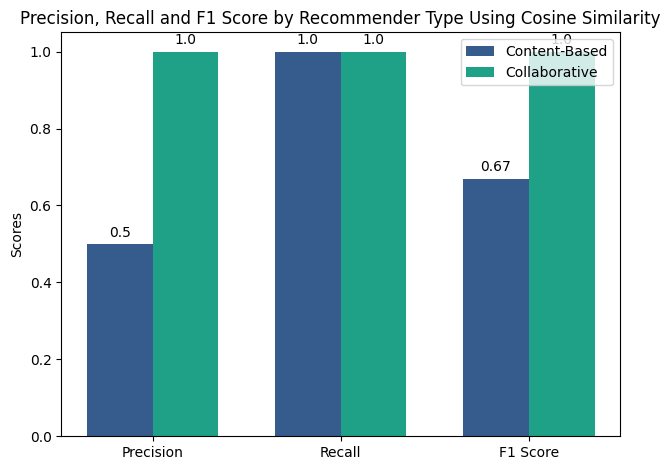

In [571]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Assume content_precision, content_recall, content_f1, collab_precision, collab_recall, collab_f1 are already defined
# Example values for demonstration purposes
content_precision, content_recall, content_f1 = content_precision_cos, content_recall_cos, content_f1_cos
collab_precision, collab_recall, collab_f1 = collab_precision_cos, collab_recall_cos, collab_f1_cos

# Data for the metrics
metrics = ['Precision', 'Recall', 'F1 Score']
content_metrics = [round(content_precision, 1), content_recall, round(content_f1, 2)]
collab_metrics = [collab_precision, collab_recall, collab_f1]

# Create a bar chart
x = np.arange(len(metrics))
width = 0.35  # width of the bars

fig, ax = plt.subplots()

# Get colors from the viridis colormap
viridis = cm.get_cmap('viridis', 8)
content_color = viridis(2)
collab_color = viridis(4)

rects1 = ax.bar(x - width/2, content_metrics, width, label='Content-Based', color=content_color)
rects2 = ax.bar(x + width/2, collab_metrics, width, label='Collaborative', color=collab_color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall and F1 Score by Recommender Type Using Cosine Similarity')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add labels above the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


<ipython-input-572-55d3cbe7e512>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 8)


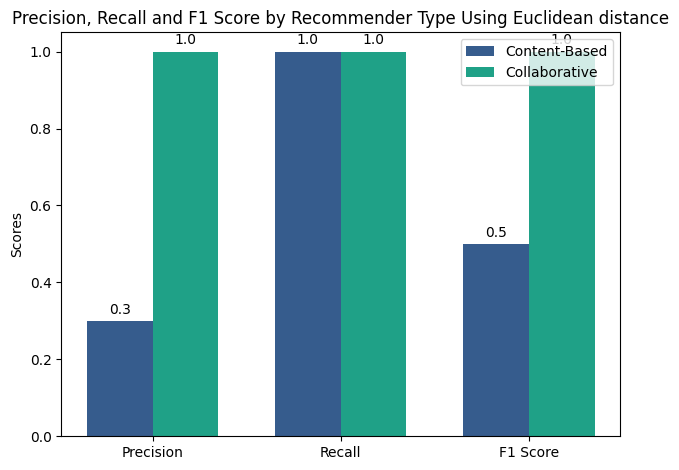

In [572]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Assume content_precision, content_recall, content_f1, collab_precision, collab_recall, collab_f1 are already defined
# Example values for demonstration purposes
content_precision, content_recall, content_f1 = content_precision_euc, content_recall_euc, content_f1_euc
collab_precision, collab_recall, collab_f1 = collab_precision_euc, collab_recall_euc, collab_f1_euc

# Data for the metrics
metrics = ['Precision', 'Recall', 'F1 Score']
content_metrics = [round(content_precision, 1), content_recall, round(content_f1, 2)]
collab_metrics = [collab_precision, collab_recall, collab_f1]

# Create a bar chart
x = np.arange(len(metrics))
width = 0.35  # width of the bars

fig, ax = plt.subplots()

# Get colors from the viridis colormap
viridis = cm.get_cmap('viridis', 8)
content_color = viridis(2)
collab_color = viridis(4)

rects1 = ax.bar(x - width/2, content_metrics, width, label='Content-Based', color=content_color)
rects2 = ax.bar(x + width/2, collab_metrics, width, label='Collaborative', color=collab_color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall and F1 Score by Recommender Type Using Euclidean distance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add labels above the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
